## WIDER Dataset - DataLoader

In [1]:
# !pip install --upgrade torch --quiet

In [1]:
import json
import io
import boto3
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import numpy as np
from PIL import Image
from torchvision.transforms import transforms, RandAugment
import torch
import tarfile
import os
import getpass
import s3fs
import json
from urllib.parse import urlparse

### Data Download - Do not need to repeat this step

In [2]:
# Option 1
# # !aws s3 cp s3://210bucket/wider_attribute_image.tgz ./wider_attribute_image.tgz
# Option 2
# s3 = boto3.client('s3')
# s3.download_file('210bucket', 'wider_attribute_image.tgz', 'wider_attribute_image.tgz')

In [3]:
# # Extract the .tgz file
# with tarfile.open('wider_attribute_image.tgz', 'r:gz') as tar:
#     tar.extractall(path="local_wider")

In [4]:
# # Upload the image files to s3 Bukcet
# s3 = boto3.client('s3')

# def upload_dir_to_s3(bucket_name, s3_folder, local_dir):
#     for root, dirs, files in os.walk(local_dir):
#         for file in files:
#             local_path = os.path.join(root, file)
#             relative_path = os.path.relpath(local_path, local_dir)
#             s3_path = os.path.join(s3_folder, relative_path)
            
#             s3.upload_file(local_path, bucket_name, s3_path)

# upload_dir_to_s3('210bucket', 'WIDER/', 'WIDER/Image/')


### DataLoader

In [5]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):
        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ]
        )
        self.anns = []
        self.s3_client = boto3.client('s3') 
        self.load_anns()
        print(self.augment)

        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                ]
            )

    def extract_label_from_filename(self, file_name):
        # Split the path and extract the part with '--'
        parts = file_name.split('/')
        for part in parts:
            if '--' in part:
                # Extract the numeric part before '--'
                label = part.split('--')[0]
                if label.isdigit():
                    return int(label)  # Return as an integer
        raise ValueError(f"Label not found in file name: {file_name}")

        

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs: # need to review RandAugment()
            t.append(RandAugment())
            # t.append(transforms.RandomApply([
            #     transforms.RandomRotation(degrees=10),
            #     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            #     transforms.RandomPerspective(distortion_scale=0.05)
            # ], p=0.5))

        t.append(transforms.Resize((img_size, img_size)))
    
        return transforms.Compose(t)

    def load_anns(self):
        s3_client = boto3.client('s3')
        self.anns = []
        for ann_file in self.ann_files:
            bucket, key = self.parse_s3_path(ann_file)
            response = s3_client.get_object(Bucket=bucket, Key=key)
            json_data = json.loads(response['Body'].read())
            for image in json_data['images']:
                file_name = image['file_name']
                label = self.extract_label_from_filename(file_name)  # Use the new method
                for target in image['targets']:
                    ann = {
                        'img_path': f's3://210bucket/WIDER/{file_name}',
                        'bbox': target['bbox'],
                        'label': label,  
                        'target': target['attribute']
                    }
                    self.anns.append(ann)
        print(f"Loaded annotations: {len(self.anns)}")


    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        idx = idx % len(self)
        ann = self.anns[idx]
    
        if not isinstance(ann, dict) or "img_path" not in ann:
            raise ValueError(f"Annotation at index {idx} is not a dictionary with an 'img_path' key: {ann}")
    
        bucket, key = self.parse_s3_path(ann["img_path"])
        try:
            response = self.s3_client.get_object(Bucket=bucket, Key=key)
            img = Image.open(io.BytesIO(response['Body'].read())).convert("RGB")
        except self.s3_client.exceptions.NoSuchKey:
            print(f"File not found: s3://{bucket}/{key}")
            img = self.get_placeholder_image()
            return None 
    
        x, y, w, h = ann['bbox']
        img = img.crop((x, y, x + w, y + h))
        img = self.augment(img)
        img = self.transform(img)
    
        label = torch.tensor(ann['label'], dtype=torch.long)    
        target = torch.tensor(ann['target'], dtype=torch.float32)
    
        message = {
            "label": label,  
            "target": target,  
            "img": img 
        }
    
        return message


    def get_placeholder_image(self):
        return Image.new('RGB', (256, 256), color = 'gray')

    @staticmethod
    def parse_s3_path(s3_path):
        if not s3_path.startswith("s3://"):
            raise ValueError(f"Invalid S3 path: {s3_path}")
        s3_path = s3_path[5:]
        bucket, key = s3_path.split('/', 1)
        return bucket, key

In [6]:

def load_wider(batch_size=64, subset_size=None):

    train_augs = ['randomflip', 'ColorJitter', 'resizedcrop', 'RandAugment']
    test_augs = []  
    img_size = 256 
    
    train_dataset = DataSet(
        ann_files=['s3://210bucket/wider_attribute_annotation/wider_attribute_trainval.json'],  
        augs=train_augs,
        img_size=img_size,
        dataset='wider'
    )
    
    test_dataset = DataSet(
        ann_files=['s3://210bucket/wider_attribute_annotation/wider_attribute_test.json'], 
        augs=test_augs,
        img_size=img_size,
        dataset='wider'
    )
    
    if subset_size is not None:
        train_indices = np.random.choice(len(train_dataset), subset_size, replace=False)
        test_indices = np.random.choice(len(test_dataset), subset_size, replace=False)
        
        train_subset = Subset(train_dataset, train_indices)
        test_subset = Subset(test_dataset, test_indices)
        
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


In [7]:
trainloader, testloader  = load_wider(batch_size=64, subset_size=1000)

Loaded annotations: 28345
Compose(
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None)
    RandomResizedCrop(size=(256, 256), scale=(0.7, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
)
Loaded annotations: 29179
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
)


## Testing - RKD Training

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import boto3
import io

# new libraries
from models_package.models import Teacher, Student, CustomResNet18
from torchvision import datasets, transforms, models
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss, DD_loss, AD_loss, RKDDistanceLoss, RKDAngleLoss

In [28]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    batch = next(iter(dataloader))
    inputs = batch['img']  # Adjust this key based on how your dataset returns a batch
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    # Measure inference time for teacher
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    # Measure inference time for student
    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time


def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)  # Use the correct key for your data
        labels = batch['label']  # Use the correct key for your labels
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(torch.argmax(teacher_outputs, dim=1).cpu().numpy())
        all_student_preds.append(torch.argmax(student_outputs, dim=1).cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return metrics


def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

In [29]:
# Hyperparameters
learning_rate = 0.04 
num_epochs = 1 
num_workers = 2
batch_size = 32
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 61
step_size = 30
gamma = 0.1

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
weight_decay_input = 5e-4
# epochs = 20
# T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping


In [30]:
###################### Testing 1 ######################
# Create instances of your models
teacher_model = models.resnet50(pretrained=True)  # Keep ResNet50 as it is
teacher_model.eval()  # Set teacher model to evaluation mode
student_model = CustomResNet18()

In [12]:
# Ensure the final classification layer is added to the model
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 61)
student_model.fc = nn.Linear(student_model.output_size, 61)

# Optimizer and scheduler for the student model
optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# teacher_model.to(device)
# student_model.to(device)


In [23]:
# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, patience=5):
    model.train()
    model.to(device)
    best_train_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for i, batch in enumerate(tqdm(trainloader)):
            inputs = batch['img'].to(device)
            labels = batch['label'].to(device)
            # print(inputs.shape)  
            # print(labels.shape) 
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  
        
        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            # checkpoint
            torch.save(model.state_dict(), f'teacher_model_weights_rkd_prof_checkpoint.pth')
            torch.save(model, f'teacher_model_rkd_prof_checkpoint.pth')

        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break

        scheduler.step()

    print("Finished Training Teacher")


# Function to train the student model with knowledge distillation
def train_student_with_distillation(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs, patience=5):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    best_train_loss = float('inf')  
    patience_counter = 0 

    for epoch in range(num_epochs):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        for i, batch in enumerate(tqdm(trainloader)):
            inputs = batch['img'].to(device)
            labels = batch['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            # ce_loss = criterion(student_outputs, labels)
            # kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # from utils.loss_functions
            # loss = alpha * kd_loss + (1 - alpha) * ce_loss

            distance_loss = RKDDistanceLoss()(student_outputs, teacher_outputs)
            angle_loss = RKDAngleLoss()(student_outputs, teacher_outputs)
            loss = criterion(student_outputs, labels) + 0.1 * (distance_loss + angle_loss)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  

        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            torch.save(student.state_dict(), f'student_model_weights_rkd_prof_checkpoint.pth')
            torch.save(student, f'student_model_rkd_prof_checkpoint.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step() 

    print("Finished Training Student")

In [24]:
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)

# Call the function to train the student model with knowledge distillation
train_student_with_distillation(student_model, teacher_model, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=num_epochs)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:26<00:00,  5.40s/it]


Finished Training Teacher


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:09<00:00,  4.32s/it]

Finished Training Student


In [ ]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


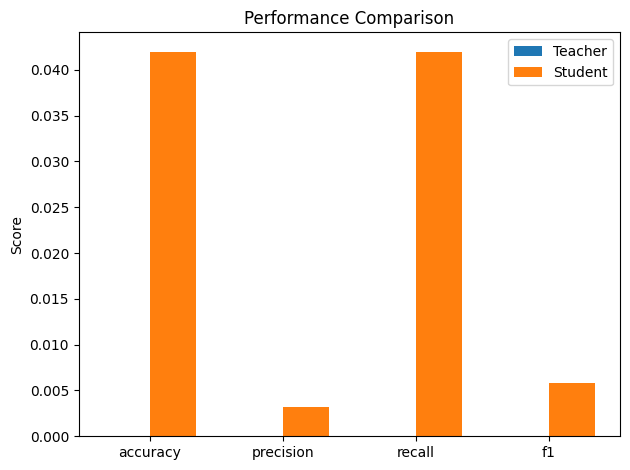

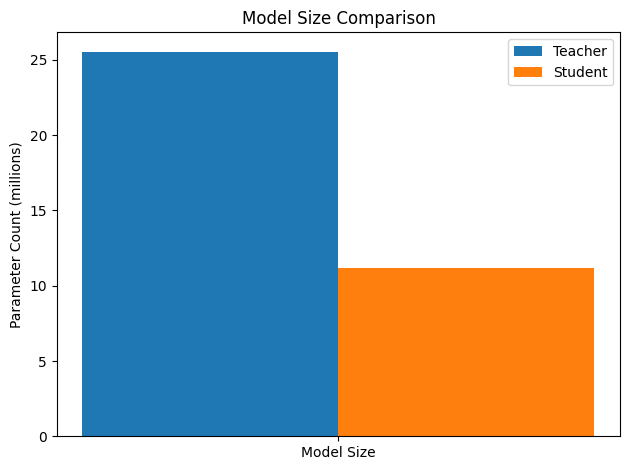

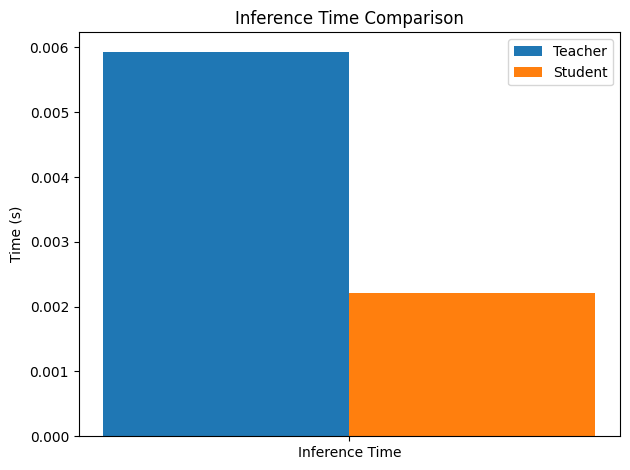

In [32]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


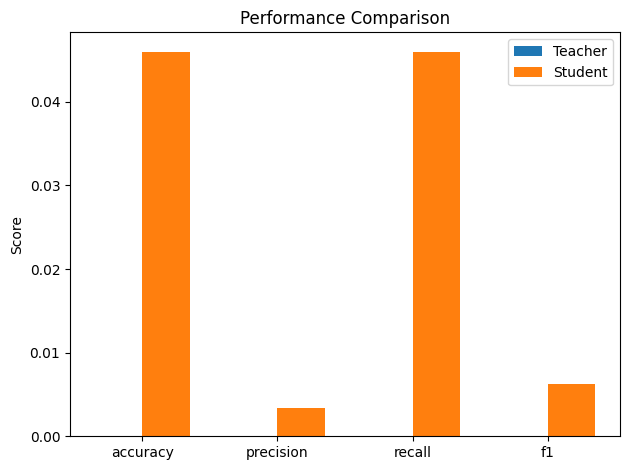

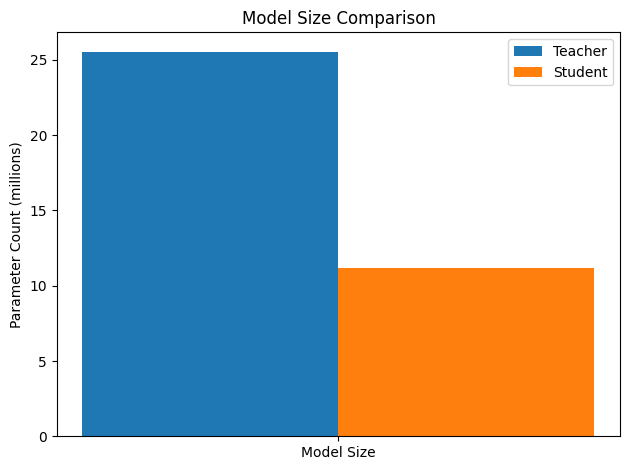

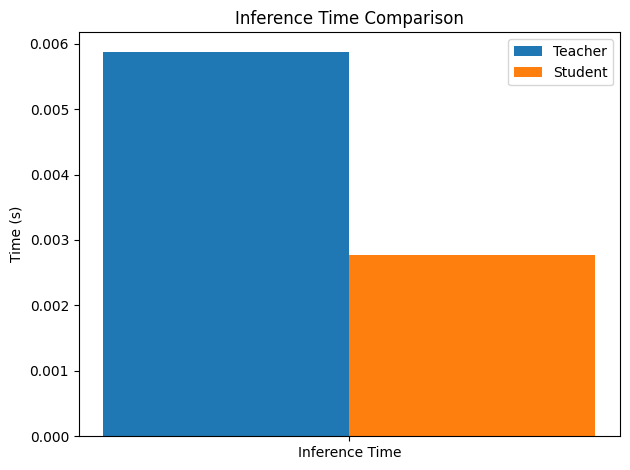

In [31]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')